In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer

In [21]:
def wrangle(file):
    df=pd.read_csv(file)
    #crating mask for capital and price and apartment
    mask_apart = df["property_type"] == "apartment"
    mask_capital = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price = df["price_aprox_usd"]<100000
    df = df[mask_apart & mask_capital & mask_price]
    #create mask foe qunatile btwenn 0.9 and 0.1 to remove outilers
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_quantil = df["surface_covered_in_m2"].between(low,high)
    df = df[mask_quantil]
    
    #separate lan and lon
    df[["lat","lon"]]=df["lat-lon"].str.split(",",expand = True)
    df.drop(columns=["lat-lon"],inplace=True)
    df[["lat","lon"]]=df[["lat","lon"]].astype(float)
    
    #creating borough columns and drop place with parent names
    
    df["borough"]=df["place_with_parent_names"].str.split("|",expand=True)[1]
    df.drop(columns=["place_with_parent_names"],inplace=True)
    
    #drop any col with more than 0.5% Nan value
    df.drop(columns=["surface_total_in_m2","price_usd_per_m2","floor","rooms","expenses"],inplace=True)
    

    #drop col with high low cardinailty
    df.drop(columns=["operation","property_type","currency","properati_url"],inplace=True)
    
    #drop any col that cause data leakague
    df.drop(columns=["price","price_aprox_local_currency","price_per_m2"],inplace=True)
    
    #there is no col that cause multicolinearity


    return df

In [22]:
files=glob("data/mexico-city-real-estate-*.csv")

In [23]:
df = pd.concat([wrangle(file) for file in files],axis=0,ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        4417 non-null   float64
 1   surface_covered_in_m2  4417 non-null   float64
 2   lat                    4173 non-null   float64
 3   lon                    4173 non-null   float64
 4   borough                4417 non-null   object 
dtypes: float64(4), object(1)
memory usage: 172.7+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [24]:
df.describe()

,price_aprox_usd,surface_covered_in_m2,lat,lon
count,4417.000000,4417.000000,4173.000000,4173.000000
mean,54295.240050,66.671723,19.455115,-99.182602
std,20576.454598,11.187568,0.477913,0.449581
min,7823.940000,48.000000,19.194247,-102.552788
25%,38206.750000,60.000000,19.365723,-99.180528
50%,50901.940000,65.000000,19.400623,-99.146974
75%,68861.230000,75.000000,19.451780,-99.122536
max,99864.560000,91.000000,23.634501,-90.488467


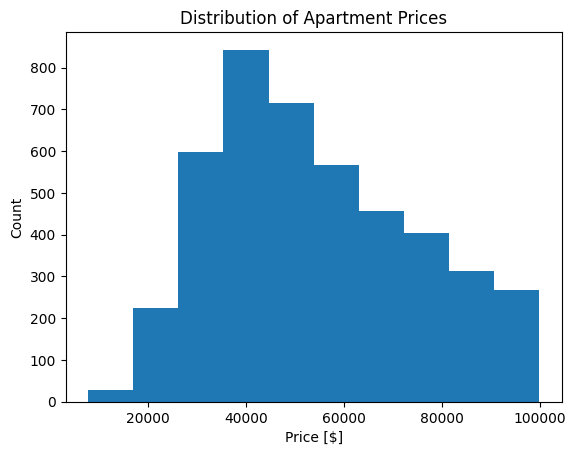

In [25]:
# Build histogram
plt.hist(df["price_aprox_usd"])

# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")


# Add title
plt.title("Distribution of Apartment Prices");

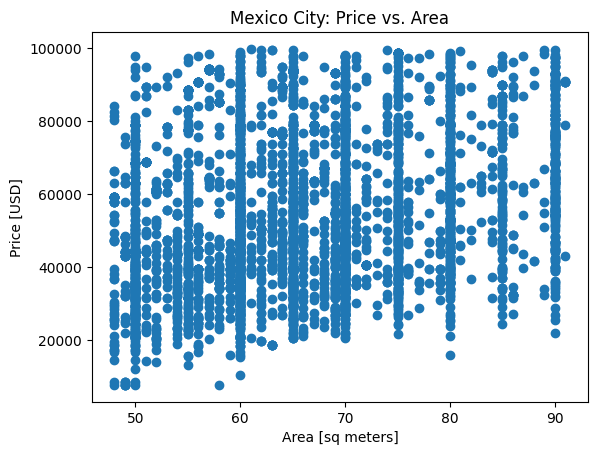

In [26]:
# Build scatter plot
plt.scatter(df["surface_covered_in_m2"],df["price_aprox_usd"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area");

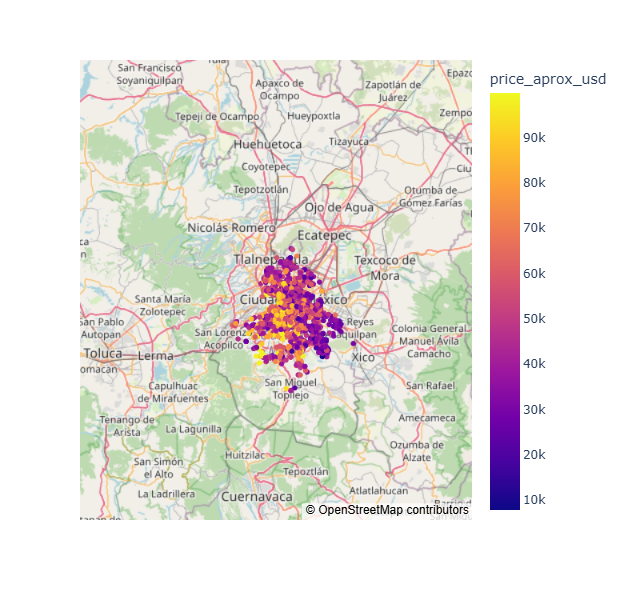

In [27]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat="lat",
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [28]:
# Split data into feature matrix `X_train` and target vector `y_train`.
features = ["surface_covered_in_m2","lat","lon","borough"]
target="price_aprox_usd"
X_train = df[features]
y_train = df[target]

In [29]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_pred_baseline,y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54295.240049807566
Baseline MAE: 17285.090229648154


In [30]:
# Build Model
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      SimpleImputer(),
                     Ridge())
# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [31]:
df_test = wrangle("data/mexico-city-test-features.csv")
X_test=df_test[features]
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1056 entries, 1 to 4618
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1056 non-null   float64
 1   lat                    976 non-null    float64
 2   lon                    976 non-null    float64
 3   borough                1056 non-null   object 
dtypes: float64(3), object(1)
memory usage: 41.2+ KB
None


,surface_covered_in_m2,lat,lon,borough
1,75.0,19.362690,-99.150565,Benito Juárez
3,62.0,19.291345,-99.124312,Tlalpan
4,85.0,19.354987,-99.061709,Iztapalapa
13,52.0,19.469681,-99.086136,Gustavo A. Madero
18,53.0,19.443592,-99.121407,Venustiano Carranza


In [32]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    69371.366352
1    60433.498702
2    44873.541651
3    41922.455300
4    43055.549111
dtype: float64

In [36]:
print(f"mean absolute error is {mean_absolute_error(y_test_pred,df_test[target])}")

mean absolute error is 14878.947791903967


In [38]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients,index=features)
feat_imp

surface_covered_in_m2               290.379405
lat                                 409.572094
lon                               -2443.026534
borough_Benito Juárez             14085.365243
borough_Iztacalco                   900.812458
borough_Azcapotzalco               2013.600878
borough_Coyoacán                   3780.552384
borough_Álvaro Obregón             3357.757204
borough_Iztapalapa               -13096.021006
borough_Cuauhtémoc                 -279.114414
borough_Tláhuac                  -14311.108259
borough_Miguel Hidalgo             2371.447819
borough_Venustiano Carranza       -5804.006527
borough_Tlalpan                    9015.787552
borough_Gustavo A. Madero         -6571.238270
borough_Xochimilco                 1028.205351
borough_La Magdalena Contreras    -5760.299611
borough_Cuajimalpa de Morelos      9268.259199
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

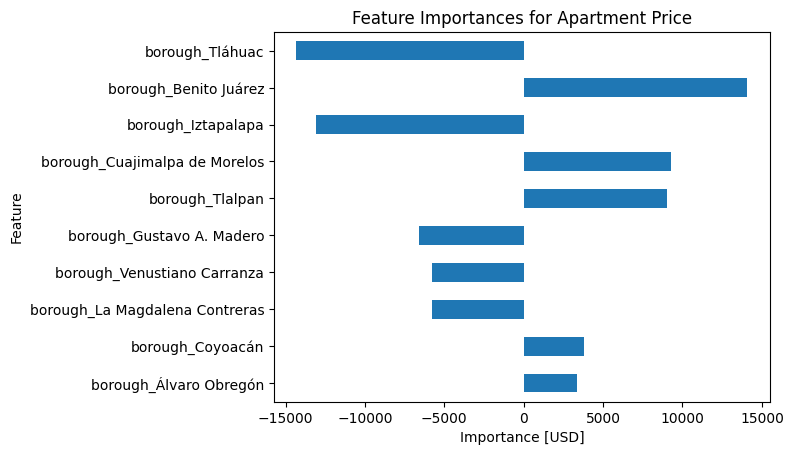

In [39]:
# Build bar chart
(feat_imp.sort_values(key=abs)
         .tail(10).plot(kind="barh"))


# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")


# Add title
plt.title("Feature Importances for Apartment Price")